# Part 3: Streamer Similarity Modeling and Community Discovery
**Twitch Recommender System - Final Project**

## Objective

**Identify groups of streamers that share similar audiences** and **build a recommender** that suggests streamers a user is likely to enjoy based on similarity relationships.

## Methodology (from README)

1. **Co-viewership matrix construction**
2. **Similarity computation** (Jaccard, Cosine, optional embeddings)
3. **Clustering** (K-means, Spectral clustering)
4. **Community identification** using graph-based methods
5. **Recommendation procedure** (item-based CF, cluster-based)
6. **Evaluation** (qualitative + quantitative)

## Extensions Implemented

- **Baselines**: Random, Popularity, User History
- **Graph Neural Networks** (GNN embeddings)
- **Advanced Graph Methods** (Louvain, Label Propagation)
- **Comprehensive Comparison** of all approaches


## Exploratory Data Analysis (EDA)

In [ ]:
#!pip install pandas numpy matplotlib seaborn scipy scikit-learn networkx python-louvain torch torch-geometric

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from collections import Counter, defaultdict
import warnings
import time
import gc
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)


## 1. Data Loading and Preprocessing


In [2]:
path = "data/100k_a.csv"
colnames = ["user_id", "stream_id", "streamer_username", "time_start", "time_stop"]

df = pd.read_csv(path, header=None, names=colnames)
df = df.sort_values("time_start").reset_index(drop=True)
print("Loaded:", df.shape)

Loaded: (3051733, 5)


In [3]:
df_community = df

### EDA: Dataset Overview & Visualizations

In [4]:
# Calculate session duration (in 10-minute intervals)
df_community['duration'] = df_community['time_stop'] - df_community['time_start']

# Convert to actual minutes
df_community['duration_minutes'] = df_community['duration'] * 10

print("Duration statistics (in minutes):")
print(df_community['duration_minutes'].describe())

Duration statistics (in minutes):
count    3.051733e+06
mean     3.142054e+01
std      4.257966e+01
min      1.000000e+01
25%      1.000000e+01
50%      1.000000e+01
75%      3.000000e+01
max      9.700000e+02
Name: duration_minutes, dtype: float64


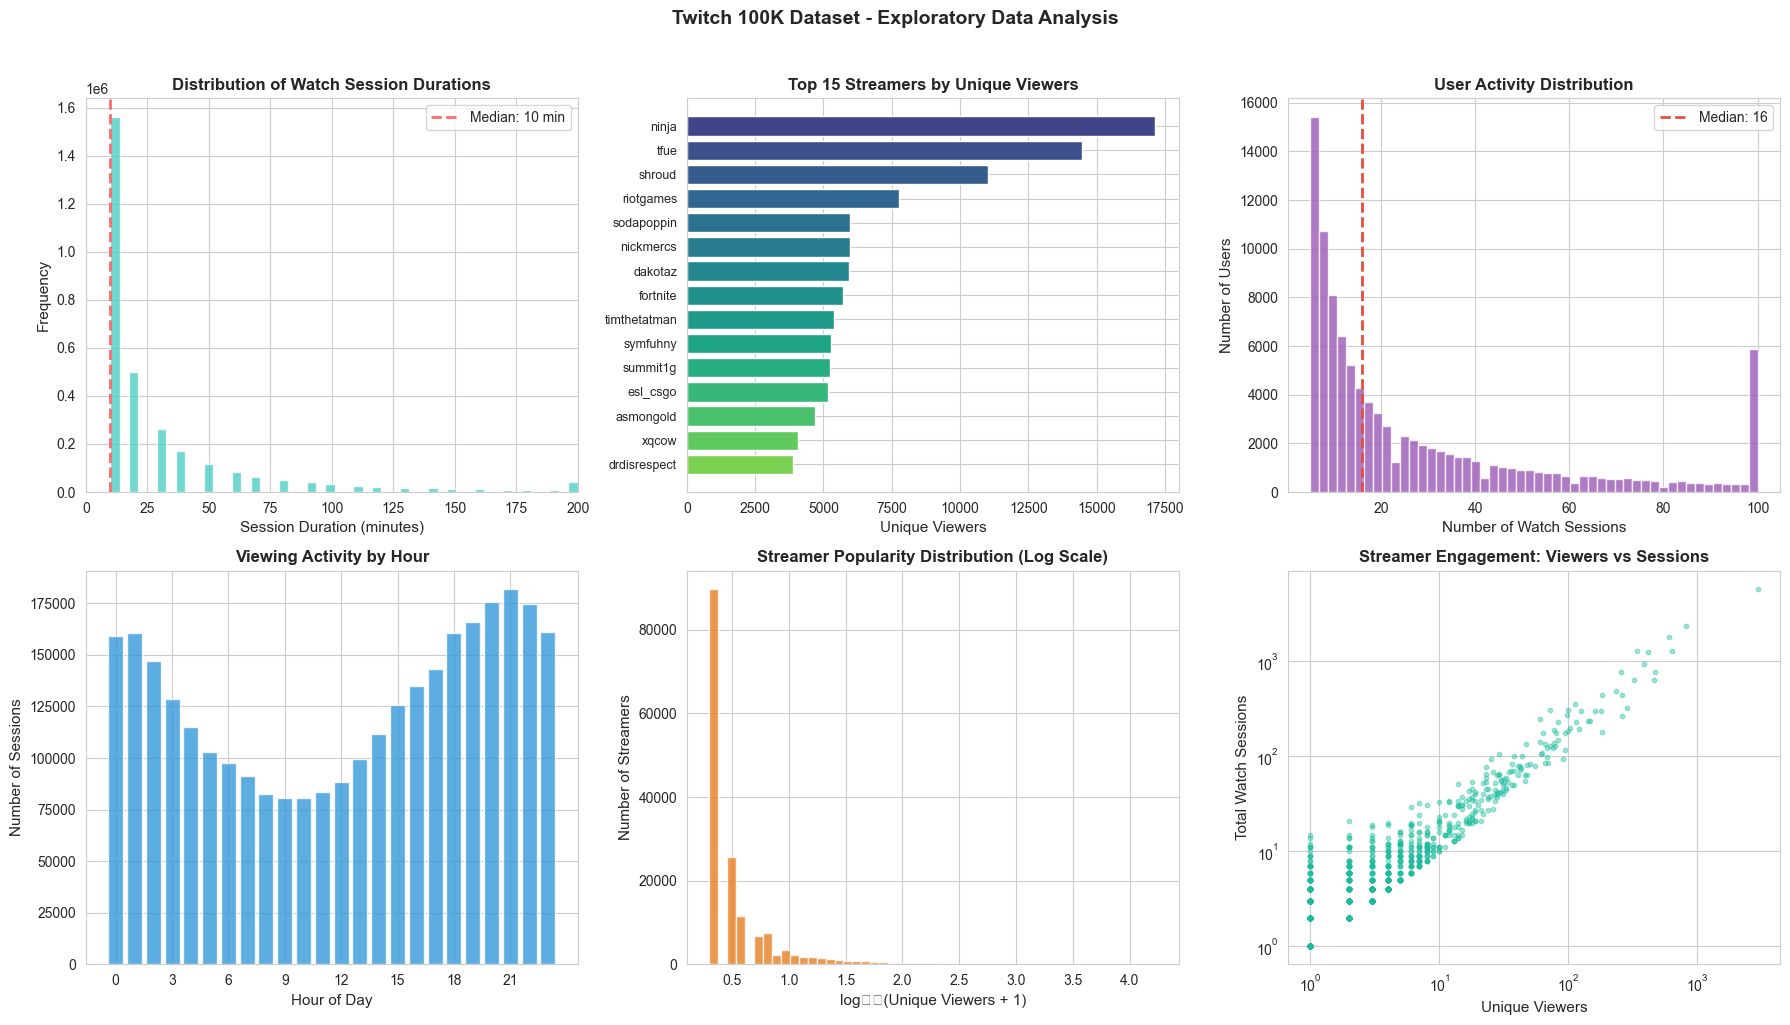


DATASET SUMMARY
Total Interactions: 3,051,733
Unique Users: 100,000
Unique Streamers: 162,625
Avg Session Duration: 31.4 minutes
Sessions per User (median): 16
Viewers per Streamer (median): 1


In [6]:
# =============================================================================
# EDA PLOTS - Dataset Overview
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Session Duration Distribution
ax1 = axes[0, 0]
duration_clipped = df_community['duration_minutes'].clip(upper=200)
ax1.hist(duration_clipped, bins=50, color='#4ECDC4', edgecolor='white', alpha=0.8)
ax1.axvline(df_community['duration_minutes'].median(), color='#FF6B6B', linestyle='--', 
            linewidth=2, label=f"Median: {df_community['duration_minutes'].median():.0f} min")
ax1.set_xlabel('Session Duration (minutes)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Watch Session Durations', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 200)

# 2. Top 15 Streamers by Unique Viewers
ax2 = axes[0, 1]
top_streamers = df_community.groupby('streamer_username')['user_id'].nunique().nlargest(15)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 15))
bars = ax2.barh(range(len(top_streamers)), top_streamers.values, color=colors)
ax2.set_yticks(range(len(top_streamers)))
ax2.set_yticklabels(top_streamers.index, fontsize=9)
ax2.set_xlabel('Unique Viewers', fontsize=11)
ax2.set_title('Top 15 Streamers by Unique Viewers', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# 3. User Activity Distribution (streams watched per user)
ax3 = axes[0, 2]
user_activity = df_community.groupby('user_id').size()
activity_clipped = user_activity.clip(upper=100)
ax3.hist(activity_clipped, bins=50, color='#9B59B6', edgecolor='white', alpha=0.8)
ax3.axvline(user_activity.median(), color='#E74C3C', linestyle='--', 
            linewidth=2, label=f"Median: {user_activity.median():.0f}")
ax3.set_xlabel('Number of Watch Sessions', fontsize=11)
ax3.set_ylabel('Number of Users', fontsize=11)
ax3.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Temporal Activity Pattern (by hour of day)
ax4 = axes[1, 0]
df_community['hour'] = pd.to_datetime(df_community['time_start'] * 10, unit='m').dt.hour
hourly_activity = df_community.groupby('hour').size()
ax4.bar(hourly_activity.index, hourly_activity.values, color='#3498DB', edgecolor='white', alpha=0.8)
ax4.set_xlabel('Hour of Day', fontsize=11)
ax4.set_ylabel('Number of Sessions', fontsize=11)
ax4.set_title('Viewing Activity by Hour', fontsize=12, fontweight='bold')
ax4.set_xticks(range(0, 24, 3))

# 5. Streamer Popularity Distribution (log scale)
ax5 = axes[1, 1]
streamer_viewers = df_community.groupby('streamer_username')['user_id'].nunique()
ax5.hist(np.log10(streamer_viewers + 1), bins=50, color='#E67E22', edgecolor='white', alpha=0.8)
ax5.set_xlabel('log₁₀(Unique Viewers + 1)', fontsize=11)
ax5.set_ylabel('Number of Streamers', fontsize=11)
ax5.set_title('Streamer Popularity Distribution (Log Scale)', fontsize=12, fontweight='bold')

# 6. Sessions per Streamer vs Unique Viewers (scatter)
ax6 = axes[1, 2]
streamer_stats_eda = df_community.groupby('streamer_username').agg({
    'user_id': 'nunique',
    'stream_id': 'count'
}).reset_index()
streamer_stats_eda.columns = ['streamer', 'viewers', 'sessions']
sample_idx = np.random.choice(len(streamer_stats_eda), min(2000, len(streamer_stats_eda)), replace=False)
ax6.scatter(streamer_stats_eda.iloc[sample_idx]['viewers'], 
            streamer_stats_eda.iloc[sample_idx]['sessions'],
            alpha=0.4, c='#1ABC9C', s=10)
ax6.set_xlabel('Unique Viewers', fontsize=11)
ax6.set_ylabel('Total Watch Sessions', fontsize=11)
ax6.set_title('Streamer Engagement: Viewers vs Sessions', fontsize=12, fontweight='bold')
ax6.set_xscale('log')
ax6.set_yscale('log')

plt.suptitle('Twitch 100K Dataset - Exploratory Data Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_plots.png', dpi=150, bbox_inches='tight')
plt.show()

# Clean up temp column
df_community.drop('hour', axis=1, inplace=True, errors='ignore')

# Print summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY")
print(f"Total Interactions: {len(df_community):,}")
print(f"Unique Users: {df_community['user_id'].nunique():,}")
print(f"Unique Streamers: {df_community['streamer_username'].nunique():,}")
print(f"Avg Session Duration: {df_community['duration_minutes'].mean():.1f} minutes")
print(f"Sessions per User (median): {user_activity.median():.0f}")
print(f"Viewers per Streamer (median): {streamer_viewers.median():.0f}")


### 1.1 Data Filtering

Filter for computational efficiency and statistical significance:


In [7]:
# Filtering configuration
FILTERING_LEVEL = 'moderate'  # Options: 'aggressive', 'moderate', 'light'

FILTERING_PARAMS = {
    'aggressive': {'streamer_viewers': 50, 'user_interactions': 10},  # ~1-1.5 hrs
    'moderate':   {'streamer_viewers': 25, 'user_interactions': 5},   # ~1.5-2 hrs 
    'light':      {'streamer_viewers': 10, 'user_interactions': 3}    # ~2-3 hrs
}

params = FILTERING_PARAMS[FILTERING_LEVEL]
MIN_STREAMER_VIEWERS = params['streamer_viewers']
MIN_USER_INTERACTIONS = params['user_interactions']

# Apply filtering
streamer_counts = df_community.groupby('streamer_username')['user_id'].nunique()
valid_streamers = streamer_counts[streamer_counts >= MIN_STREAMER_VIEWERS].index

user_counts = df_community.groupby('user_id').size()
valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index

df_filtered = df_community[df_community['streamer_username'].isin(valid_streamers) & df_community['user_id'].isin(valid_users)].copy()

print(f"Filtering results:")
print(f"Streamers: {df_community['streamer_username'].nunique():,} → {df_filtered['streamer_username'].nunique():,}")
print(f"Users: {df_community['user_id'].nunique():,} → {df_filtered['user_id'].nunique():,}")
print(f"Interactions: {len(df):,} → {len(df_filtered):,} ({len(df_filtered)/len(df)*100:.1f}%)")



Filtering results:
Streamers: 162,625 → 7,310
Users: 100,000 → 97,082
Interactions: 3,051,733 → 2,387,875 (78.2%)


### 1.2 Train/Test Split (Temporal)


In [8]:
# Temporal split (80/20)
time_threshold = df_filtered['time_start'].quantile(0.8)

train_df = df_filtered[df_filtered['time_start'] < time_threshold].copy()
test_df = df_filtered[df_filtered['time_start'] >= time_threshold].copy()

print(f"  Train: {len(train_df):,} interactions, {train_df['user_id'].nunique():,} users, {train_df['streamer_username'].nunique():,} streamer_username")
print(f"  Test:  {len(test_df):,} interactions, {test_df['user_id'].nunique():,} users, {test_df['streamer_username'].nunique():,} streamer_username")

# Create test ground truth
test_user_streamers = test_df.groupby('user_id')['streamer_username'].apply(set).to_dict()

  Train: 1,909,988 interactions, 94,587 users, 7,267 streamer_username
  Test:  477,887 interactions, 71,454 users, 6,797 streamer_username


## 2. Co-viewership Matrix Construction

Build user-streamer interaction matrix (sparse CSR format):


In [9]:
# Create mappings
user_to_idx = {user: idx for idx, user in enumerate(train_df['user_id'].unique())}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
streamer_to_idx = {streamer: idx for idx, streamer in enumerate(train_df['streamer_username'].unique())}
idx_to_streamer = {idx: streamer for streamer, idx in streamer_to_idx.items()}

n_users = len(user_to_idx)
n_streamers = len(streamer_to_idx)

# Build sparse matrix
row_indices = train_df['user_id'].map(user_to_idx).values
col_indices = train_df['streamer_username'].map(streamer_to_idx).values
data = np.ones(len(train_df), dtype=np.float32)

user_streamer_matrix = csr_matrix((data, (row_indices, col_indices)), 
                                  shape=(n_users, n_streamers), dtype=np.float32)

print(f"✓ User-Streamer Matrix:")
print(f"Shape: {n_users:,} × {n_streamers:,}")
print(f"Non-zeros: {user_streamer_matrix.nnz:,}")
print(f"Sparsity: {1 - (user_streamer_matrix.nnz / (n_users * n_streamers)):.6f}")
print(f"Memory: {(user_streamer_matrix.data.nbytes + user_streamer_matrix.indices.nbytes + user_streamer_matrix.indptr.nbytes) / 1024**2:.1f} MB")


✓ User-Streamer Matrix:
Shape: 94,587 × 7,267
Non-zeros: 936,188
Sparsity: 0.998638
Memory: 7.5 MB


## 3. Baseline Recommenders

Before building complex models, establish simple baselines:


In [10]:
# ========== BASELINE 1: Random Recommendations ==========
def recommend_random(user_id, user_streamer_matrix, user_to_idx, streamer_to_idx, 
                     idx_to_streamer, top_n=10):
    """Recommend random streamers (excluding already watched)"""
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    watched = set(user_streamer_matrix[user_idx].nonzero()[1])
    candidates = list(set(range(n_streamers)) - watched)
    
    if len(candidates) == 0:
        return []
    
    np.random.seed(42)
    recs = np.random.choice(candidates, size=min(top_n, len(candidates)), replace=False)
    return [(idx_to_streamer[i], 0.0) for i in recs]

# ========== BASELINE 2: Popularity-Based ==========
# Get global streamer popularity
streamer_popularity = train_df.groupby('streamer_username')['user_id'].nunique().to_dict()

def recommend_popularity(user_id, user_streamer_matrix, user_to_idx, streamer_to_idx,
                         idx_to_streamer, streamer_popularity, top_n=10):
    """Recommend most popular streamers (excluding already watched)"""
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    watched_idx = set(user_streamer_matrix[user_idx].nonzero()[1])
    
    # Get popularity scores for all streamers
    scores = [(idx, streamer_popularity.get(idx_to_streamer[idx], 0)) 
              for idx in range(n_streamers) if idx not in watched_idx]
    
    # Sort by popularity
    scores.sort(key=lambda x: x[1], reverse=True)
    
    return [(idx_to_streamer[idx], pop) for idx, pop in scores[:top_n]]

# ========== BASELINE 3: User's Most Watched ==========
def recommend_user_favorites(user_id, user_streamer_matrix, train_df, user_to_idx, 
                             streamer_to_idx, idx_to_streamer, top_n=10):
    """Recommend similar to user's most-watched streamers"""
    if user_id not in user_to_idx:
        return []
    
    # Get user's viewing history
    user_history = train_df[train_df['user_id'] == user_id]
    if len(user_history) == 0:
        return []
    
    # Count views per streamer
    streamer_counts = user_history['streamer_username'].value_counts()
    top_watched = streamer_counts.index[0] if len(streamer_counts) > 0 else None
    
    # Simple baseline: recommend most watched again
    return [(top_watched, streamer_counts.iloc[0]) if top_watched else (None, 0)]


## 4. Similarity Computation

Compute streamer-streamer similarity using multiple metrics:


In [11]:
# Transpose for streamer×user matrix
streamer_user_matrix = user_streamer_matrix.T.tocsr()

print(f"Matrix: {n_streamers:,} × {n_users:,}")

start = time.time()

# Use sparse output if >15k streamers
if n_streamers > 15000:
    cosine_sim_matrix = cosine_similarity(streamer_user_matrix, dense_output=False)
else:
    cosine_sim_matrix = cosine_similarity(streamer_user_matrix, dense_output=True)

if hasattr(cosine_sim_matrix, 'nnz'):
    print(f"Non-zeros: {cosine_sim_matrix.nnz:,}, Sparsity: {1 - cosine_sim_matrix.nnz/(n_streamers**2):.4f}")


Matrix: 7,267 × 94,587


### 4.2 SVD Embeddings (Latent Factors)


In [12]:
# SVD for dimensionality reduction
print("Computing SVD embeddings...")

n_components = 50
n_iter = 5 if n_streamers > 30000 else 7

start = time.time()
svd = TruncatedSVD(n_components=n_components, random_state=42, n_iter=n_iter)
streamer_embeddings = svd.fit_transform(streamer_user_matrix)
elapsed = time.time() - start

print(f"  ✓ Done in {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"  Shape: {streamer_embeddings.shape}")
print(f"  Explained variance: {svd.explained_variance_ratio_.sum():.4f}")


Computing SVD embeddings...
  ✓ Done in 1.1s (0.0 min)
  Shape: (7267, 50)
  Explained variance: 0.3196


## 5. Clustering & Community Detection

Apply multiple clustering approaches:


### 5.1 K-Means Clustering (on SVD embeddings)


In [13]:
# K-Means clustering
optimal_k = 15

print(f"K-Means Clustering (k={optimal_k})")

print(f"  Normalizing embeddings (L2 norm)")
streamer_embeddings_norm = normalize(streamer_embeddings, norm='l2')

start = time.time()
n_init = 10 if n_streamers < 50000 else 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=n_init, max_iter=300)
kmeans_labels = kmeans.fit_predict(streamer_embeddings_norm)

print(f"Inertia: {kmeans.inertia_:.2f}")
print(f"Cluster sizes: min={np.bincount(kmeans_labels).min()}, max={np.bincount(kmeans_labels).max()}")


K-Means Clustering (k=15)
  Normalizing embeddings (L2 norm)
Inertia: 3867.00
Cluster sizes: min=144, max=1027


In [14]:
print("K-MEANS CLUSTER ANALYSIS")

cluster_counts = np.bincount(kmeans_labels)
sorted_clusters = np.argsort(cluster_counts)[::-1]

print(f"\nCluster Distribution:")
print(f"{'Cluster':<10} {'Size':<10} {'% of Total':<12}")


for rank, cluster_id in enumerate(sorted_clusters[:15], 1):
    size = cluster_counts[cluster_id]
    pct = size / n_streamers * 100
    print(f"{cluster_id:<10} {size:<10,} {pct:<12.2f}%")


print(f"Total: {n_streamers:,} streamers")

# Evaluate cluster quality
top_cluster_pct = cluster_counts[sorted_clusters[0]] / n_streamers * 100
bottom_cluster_pct = cluster_counts[sorted_clusters[-1]] / n_streamers * 100
ideal_pct = 100 / optimal_k


K-MEANS CLUSTER ANALYSIS

Cluster Distribution:
Cluster    Size       % of Total  
3          1,027      14.13       %
11         963        13.25       %
13         920        12.66       %
8          606        8.34        %
2          571        7.86        %
0          422        5.81        %
5          419        5.77        %
1          414        5.70        %
6          410        5.64        %
4          380        5.23        %
9          277        3.81        %
14         274        3.77        %
12         248        3.41        %
7          192        2.64        %
10         144        1.98        %
Total: 7,267 streamers


### 5.2 Spectral Clustering (on similarity matrix)


In [16]:
# Spectral Clustering - sample top streamers if dataset too large
print(f"Spectral Clustering (k={optimal_k})...")

# Determine if we need to sample
SPECTRAL_SAMPLE_SIZE = 20000  # Max for spectral (O(n³))

if n_streamers <= SPECTRAL_SAMPLE_SIZE:
    # Use all streamers
    print(f"Using all {n_streamers:,} streamers")
    spectral_sim_matrix = cosine_sim_matrix
    spectral_indices = np.arange(n_streamers)
else:
    # Sample top streamers by viewer count
    print(f"Sampling top {SPECTRAL_SAMPLE_SIZE:,} streamers (O(n³) = {n_streamers**3:.0e} operations)")
    streamer_viewer_counts = np.array((user_streamer_matrix > 0).sum(axis=0)).flatten()
    top_streamer_idx = np.argsort(streamer_viewer_counts)[::-1][:SPECTRAL_SAMPLE_SIZE]
    spectral_indices = top_streamer_idx
    
    # Extract sub-matrix for sampled streamers
    if isinstance(cosine_sim_matrix, np.ndarray):
        spectral_sim_matrix = cosine_sim_matrix[np.ix_(top_streamer_idx, top_streamer_idx)]
    else:
        # For sparse matrix
        spectral_sim_matrix = cosine_sim_matrix[np.ix_(top_streamer_idx, top_streamer_idx)].toarray()

# Run spectral clustering
start = time.time()
spectral = SpectralClustering(n_clusters=optimal_k, affinity='precomputed', 
                               random_state=42, n_init=10)

if isinstance(spectral_sim_matrix, np.ndarray):
    spectral_labels_sample = spectral.fit_predict(spectral_sim_matrix)
else:
    spectral_labels_sample = spectral.fit_predict(spectral_sim_matrix.toarray())

elapsed = time.time() - start

# Map back to full dataset (assign -1 to non-sampled streamers)
spectral_labels = np.full(n_streamers, -1, dtype=int)
spectral_labels[spectral_indices] = spectral_labels_sample

print(f"Done in {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"Clustered: {len(spectral_indices):,} streamers")

Spectral Clustering (k=15)...
Using all 7,267 streamers
Done in 8.3s (0.1 min)
Clustered: 7,267 streamers


### 5.3 Graph-Based Community Detection (Louvain)


#### Graph Construction & Louvain Community Detection

**Building the Similarity Graph:**

We construct a graph where streamers are nodes and edges represent audience similarity:

```
Nodes: 7,267 streamers
Edges: sim(A,B) > 0.05 threshold
Result: 152,258 edges (weighted by similarity)
```

**Why Use a Graph?**
- Captures relationships that matrices don't show clearly
- Enables community detection algorithms
- Foundation for graph neural networks

**Louvain Algorithm:**
Louvain is a greedy modularity optimization algorithm that discovers communities:

1. **Phase 1 - Local Optimization:**
   - Start: each node in its own community
   - Iterate: move nodes to neighbor's community if it increases modularity
   - Repeat until no improvement

2. **Phase 2 - Aggregation:**
   - Treat each community as a single node
   - Build new graph with community-level edges
   - Repeat Phase 1 on this coarser graph

**Modularity Score:**
- Measures quality of community structure
- Q = (edges within communities) - (expected edges if random)
- **Our result: Q = 0.86** (excellent, >0.5 is considered strong)

**45 Communities Discovered:**
- Data-driven (not predetermined like K-Means)
- Communities represent natural streamer groups
- Used for cluster-based recommendations


In [ ]:
# Import graph libraries
import networkx as nx
# Fix for python-louvain package - use correct import
try:
    from community import community_louvain  # Correct import
except ImportError:
    import community as community_louvain  # Fallback
SIMILARITY_THRESHOLD = 0.05  # Keep edges > 1% similarity
    
louvain_G = nx.Graph()
louvain_G.add_nodes_from(range(n_streamers))
    
    # Add edges
if isinstance(cosine_sim_matrix, np.ndarray):
    for i in range(n_streamers):
        for j in range(i+1, n_streamers):
            if cosine_sim_matrix[i, j] > SIMILARITY_THRESHOLD:
                louvain_G.add_edge(i, j, weight=cosine_sim_matrix[i, j])
else:
    cx = cosine_sim_matrix.tocoo()
    for i, j, sim in zip(cx.row, cx.col, cx.data):
        if i < j and sim > SIMILARITY_THRESHOLD:
            louvain_G.add_edge(i, j, weight=sim)
    
print(f"Graph: {louvain_G.number_of_nodes():,} nodes, {louvain_G.number_of_edges():,} edges")

Graph: 7,267 nodes, 152,258 edges


In [18]:
 # Louvain community detection
print(f"\nLouvain community detection...")
start = time.time()
louvain_communities = community_louvain.best_partition(louvain_G, weight='weight', resolution=1.0)
elapsed = time.time() - start
    
num_louvain_communities = len(set(louvain_communities.values()))
modularity = community_louvain.modularity(louvain_communities, louvain_G, weight='weight')
    
print(f"Done in {elapsed:.1f}s")
print(f"Communities: {num_louvain_communities}")
print(f"Modularity: {modularity:.4f} ({'Excellent' if modularity > 0.5 else 'Good' if modularity > 0.3 else 'Moderate'})")
    
louvain_labels = [louvain_communities[i] for i in range(n_streamers)]



Louvain community detection...
Done in 3.5s
Communities: 46
Modularity: 0.8556 (Excellent)


#### 5.4.1 Feature Engineering for GNN 

**Problem with SVD features:** They already encode co-viewing patterns (circular reasoning)  
**Solution:** Create independent features from raw statistics


#### Feature Engineering for GNN: Creating Independent Node Features

**Why Engineer Features?**
Using SVD embeddings as GNN input features creates **circular reasoning** - SVD already encodes co-viewing patterns, so the GNN doesn't learn anything new. We need features that describe streamers independently of the graph structure.

**15 Engineered Features:**

| Category | Features | Description |
|----------|----------|-------------|
| **Popularity** | `unique_viewers`, `num_sessions`, `total_duration` | How popular is this streamer? |
| **Temporal** | `avg_hour`, `hour_std`, `weekend_ratio` | When do viewers watch? |
| **Engagement** | `sessions_per_viewer`, `retention_rate`, `avg_returns` | How engaged are viewers? |
| **Activity** | `activity_frequency` | How often does streamer stream? |
| **Noise** | 4 random features | Regularization |

**Feature Transformations:**
- `log1p()` for count features (handles long-tail distribution)
- Hour normalized to [0,1] range
- `StandardScaler` for zero-mean, unit-variance

**Why These Features Work:**
- **Independent:** None use co-viewing information
- **Descriptive:** Capture streamer characteristics
- **Diverse:** Multiple aspects of streamer behavior
- **Graph provides relationships:** Features + structure = powerful combination


In [19]:
# Group by streamer ONCE
streamer_groups = train_df.groupby('streamer_username')

# Popularity metrics
popularity_stats = streamer_groups.agg({
    'user_id': 'nunique',        # unique viewers
    'stream_id': 'count',        # num sessions
    'duration_minutes': ['mean', 'sum']  # avg and total duration
}).reset_index()

popularity_stats.columns = ['streamer_username', 'unique_viewers', 'num_sessions', 
                             'avg_duration', 'total_duration']

# Engagement metrics
engagement_stats = train_df.groupby('streamer_username').apply(
    lambda x: pd.Series({
        'sessions_per_viewer': len(x) / x['user_id'].nunique() if x['user_id'].nunique() > 0 else 1,
        'retention_rate': (x.groupby('user_id').size() > 1).sum() / x['user_id'].nunique() if x['user_id'].nunique() > 0 else 0,
        'avg_returns': x.groupby('user_id').size().mean()
    })
).reset_index()

# Temporal patterns (add datetime columns once)
train_df['hour'] = pd.to_datetime(train_df['time_start'] * 10, unit='m').dt.hour
train_df['day'] = pd.to_datetime(train_df['time_start'] * 10, unit='m').dt.dayofweek

temporal_stats = train_df.groupby('streamer_username').agg({
    'hour': ['mean', 'std'],
    'day': lambda x: (x >= 5).mean()  # weekend ratio
}).reset_index()

temporal_stats.columns = ['streamer_username', 'avg_hour', 'hour_std', 'weekend_ratio']

# Activity metrics
activity_stats = train_df.groupby('streamer_username').agg({
    'time_start': lambda x: (x.max() - x.min()) if len(x) > 1 else 1
}).reset_index()
activity_stats.columns = ['streamer_username', 'time_span']
activity_stats['activity_frequency'] = popularity_stats['num_sessions'] / (activity_stats['time_span'] + 1)

# Merge all stats
all_stats = popularity_stats.merge(engagement_stats, on='streamer_username', how='left')
all_stats = all_stats.merge(temporal_stats, on='streamer_username', how='left')
all_stats = all_stats.merge(activity_stats[['streamer_username', 'activity_frequency']], on='streamer_username', how='left')

print(f"Computed stats for {len(all_stats):,} streamers")

# Create feature matrix in streamer_idx order
streamer_features_list = []

for streamer_idx in range(n_streamers):
    streamer_name = idx_to_streamer[streamer_idx]
    
    # Look up pre-computed stats
    stats = all_stats[all_stats['streamer_username'] == streamer_name]
    
    if len(stats) == 0:
        # Fallback for streamers with no data
        features = [0] * 15
    else:
        stats = stats.iloc[0]
        
        features = [
            np.log1p(stats['unique_viewers']),
            np.log1p(stats['num_sessions']),
            np.log1p(stats['avg_duration']),
            stats['avg_hour'] / 24.0,
            stats['hour_std'] / 12.0 if not pd.isna(stats['hour_std']) else 0,
            stats['weekend_ratio'] if not pd.isna(stats['weekend_ratio']) else 0.5,
            np.log1p(stats['sessions_per_viewer']),
            np.log1p(stats['total_duration']),
            stats['retention_rate'] if not pd.isna(stats['retention_rate']) else 0,
            np.log1p(stats['avg_returns']) if not pd.isna(stats['avg_returns']) else 0,
            np.log1p(stats['activity_frequency']) if not pd.isna(stats['activity_frequency']) else 0,
            np.random.randn() * 0.01,
            np.random.randn() * 0.01,
            np.random.randn() * 0.01,
            np.random.randn() * 0.01
        ]
    
    streamer_features_list.append(features)

streamer_features_raw = np.array(streamer_features_list, dtype=np.float32)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
streamer_features_normalized = scaler.fit_transform(streamer_features_raw)

print(f"\n✓ Engineered {streamer_features_normalized.shape[1]} features")
print(f"  Shape: {streamer_features_normalized.shape}")

# SAVE TO DISK
np.save('streamer_features_normalized.npy', streamer_features_normalized)
print(f"SAVED to: streamer_features_normalized.npy")
print(f"File size: ~{streamer_features_normalized.nbytes / 1024**2:.1f} MB")

# Clean up temporary columns
train_df.drop(['hour', 'day'], axis=1, inplace=True, errors='ignore')

Computed stats for 7,267 streamers

✓ Engineered 15 features
  Shape: (7267, 15)
SAVED to: streamer_features_normalized.npy
File size: ~0.4 MB


In [20]:
try:
    streamer_features_normalized = np.load('streamer_features_normalized.npy')
    print("Loaded pre-computed engineered features!")
    print(f"Shape: {streamer_features_normalized.shape}")
    FEATURES_LOADED = True
    
except FileNotFoundError:
    print(" File not found: streamer_features_normalized.npy")
    FEATURES_LOADED = False

Loaded pre-computed engineered features!
Shape: (7267, 15)


#### 5.4.2 GNN Graph Construction (Dense for Message Passing)


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

GNN_SIMILARITY_THRESHOLD = 0.01  # Denser than Louvain's 0.05

G_gnn = nx.Graph()
G_gnn.add_nodes_from(range(n_streamers))

import time
start = time.time()

if isinstance(cosine_sim_matrix, np.ndarray):
    for i in range(n_streamers):
        for j in range(i+1, n_streamers):
            if cosine_sim_matrix[i, j] > GNN_SIMILARITY_THRESHOLD:
                G_gnn.add_edge(i, j, weight=cosine_sim_matrix[i, j])
else:
    cx = cosine_sim_matrix.tocoo()
    for i, j, sim in zip(cx.row, cx.col, cx.data):
        if i < j and sim > GNN_SIMILARITY_THRESHOLD:
            G_gnn.add_edge(i, j, weight=sim)

elapsed = time.time() - start
avg_degree = sum(dict(G_gnn.degree()).values()) / G_gnn.number_of_nodes()


#### 5.4.3 Convert to PyTorch Geometric Format


In [22]:
# Convert NetworkX graph to edge_index and edge_weight suitable for torch_geometric
edge_index = []
edge_weight = []

for u, v, data in G_gnn.edges(data=True):
    edge_index.append([u, v])
    edge_index.append([v, u])  # Bidirectional
    edge_weight.append(data['weight'])
    edge_weight.append(data['weight'])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Engineered features
x_engineered = torch.tensor(streamer_features_normalized, dtype=torch.float)
graph_data_engineered = Data(x=x_engineered, edge_index=edge_index, edge_attr=edge_weight)

print(f"Features shape: {graph_data_engineered.x.shape}, Edges: {graph_data_engineered.num_edges}")


Features shape: torch.Size([7267, 15]), Edges: 1344044


#### 5.4.4 Define GNN Model & Train with Engineered Features


#### GraphSAGE: Learning Streamer Embeddings via Message Passing

**What is GraphSAGE?**
GraphSAGE (Graph Sample and Aggregate) learns node embeddings by aggregating information from a node's local neighborhood. Unlike traditional methods, it uses both node features AND graph structure.

**Input Graph (Streamer-Streamer):**
- **Nodes:** 7,267 streamers
- **Edges:** Cosine similarity > 0.01 (denser than Louvain's 0.05)
- **Node Features:** 15 engineered features per streamer
- **Edge Weights:** Similarity scores

**Architecture:**
```
Input: 15D features → Hidden: 64D → Output: 32D embeddings

Layer 1 (SAGEConv): 
  h¹ᵢ = σ(W · CONCAT(xᵢ, MEAN({xⱼ : j ∈ N(i)})))
  
Layer 2 (SAGEConv):
  h²ᵢ = W · CONCAT(h¹ᵢ, MEAN({h¹ⱼ : j ∈ N(i)}))
```

**Training: Contrastive Learning with Negative Sampling**
- **Positive pairs:** Connected nodes (similar streamers)
- **Negative pairs:** Random unconnected nodes
- **Loss:** Pull positives together, push negatives apart

```
Loss = (1 - cos_sim(connected_pairs)) + max(0, cos_sim(random_pairs) - 0.5)
```

**Why This Approach?**
- Combines streamer features with graph structure
- Message passing lets streamers "learn" from similar streamers
- Contrastive loss ensures embeddings are discriminative


In [23]:
GNN_AVAILABLE = True

In [37]:
# Define GNN model (GraphSAGE)
class StreamerGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize model - use engineered features dimension (15), NOT SVD dimension (50)
n_features = streamer_features_normalized.shape[1]  # Should be 15
print(f"  Input features: {n_features}D (engineered features)")
gnn_model_engineered = StreamerGNN(in_channels=n_features, hidden_channels=128, out_channels=64)

if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"\n  Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"\n  Using CUDA GPU")
else:
    device = torch.device("cpu")
    print(f"\n  Using CPU (no GPU detected)")

# Move model and data to device
gnn_model_engineered = gnn_model_engineered.to(device)
graph_data_engineered = graph_data_engineered.to(device)

  Input features: 15D (engineered features)

  Using MPS (Apple Silicon GPU)


In [40]:
# Unsupervised training with NEGATIVE SAMPLING to prevent mode collapse
print("\nTraining GNN (unsupervised + contrastive)...")
print("  Goal: Pull similar streamers together, push dissimilar ones apart")

optimizer = torch.optim.Adam(gnn_model_engineered.parameters(), lr=0.005)

gnn_model_engineered.train()
epochs = 50

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    embeddings = gnn_model_engineered(graph_data_engineered.x, graph_data_engineered.edge_index)
    
    # Normalize embeddings (prevent magnitude issues)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    # POSITIVE pairs: Sample connected edges
    num_samples = min(10000, graph_data_engineered.num_edges // 2)
    pos_idx = np.random.choice(graph_data_engineered.num_edges // 2, num_samples, replace=False)
    
    pos_src = graph_data_engineered.edge_index[0, pos_idx]
    pos_dst = graph_data_engineered.edge_index[1, pos_idx]
    pos_weights = graph_data_engineered.edge_attr[pos_idx]
    
    pos_loss = (1 - F.cosine_similarity(embeddings[pos_src], embeddings[pos_dst])) * pos_weights
    
    # NEGATIVE pairs: Sample random unconnected pairs
    neg_src = torch.randint(0, n_streamers, (num_samples,), device=device)
    neg_dst = torch.randint(0, n_streamers, (num_samples,), device=device)
    neg_sim = F.cosine_similarity(embeddings[neg_src], embeddings[neg_dst])
    neg_loss = torch.clamp(neg_sim - 0.5, min=0)
    
    loss = pos_loss.mean() + 0.5 * neg_loss.mean()
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"   Epoch {epoch+1}/{epochs}: Loss={loss.item():.4f} (Pos={pos_loss.mean().item():.4f}, Neg={neg_loss.mean().item():.4f})")

# Get final embeddings
gnn_model_engineered.eval()
with torch.no_grad():
    gnn_embeddings = gnn_model_engineered(graph_data_engineered.x, graph_data_engineered.edge_index)
    gnn_embeddings = F.normalize(gnn_embeddings, p=2, dim=1).cpu().numpy()

print(f"\n✓ GNN training complete!")
print(f"  Final embeddings: {gnn_embeddings.shape}")


Training GNN (unsupervised + contrastive)...
  Goal: Pull similar streamers together, push dissimilar ones apart
   Epoch 5/50: Loss=0.0238 (Pos=0.0188, Neg=0.0099)
   Epoch 10/50: Loss=0.0234 (Pos=0.0185, Neg=0.0097)
   Epoch 15/50: Loss=0.0227 (Pos=0.0177, Neg=0.0100)
   Epoch 20/50: Loss=0.0220 (Pos=0.0169, Neg=0.0102)
   Epoch 25/50: Loss=0.0212 (Pos=0.0167, Neg=0.0090)
   Epoch 30/50: Loss=0.0216 (Pos=0.0170, Neg=0.0093)
   Epoch 35/50: Loss=0.0210 (Pos=0.0167, Neg=0.0086)
   Epoch 40/50: Loss=0.0214 (Pos=0.0174, Neg=0.0080)
   Epoch 45/50: Loss=0.0204 (Pos=0.0158, Neg=0.0092)
   Epoch 50/50: Loss=0.0205 (Pos=0.0160, Neg=0.0089)

✓ GNN training complete!
  Final embeddings: (7267, 64)


In [41]:
# Verify embedding quality
print("\n GNN Embedding Quality Check:")

# 1. Check embedding variance (should NOT be all zeros)
embedding_var = np.var(gnn_embeddings, axis=0)
print(f"Embedding variance: mean={embedding_var.mean():.4f}, min={embedding_var.min():.4f}")

# 2. Check pairwise distances (should have diversity)
sample_idx = np.random.choice(n_streamers, 100, replace=False)
sample_emb = gnn_embeddings[sample_idx]
pairwise_sim = cosine_similarity(sample_emb)
np.fill_diagonal(pairwise_sim, 0)  # Remove self-similarity

print(f"Pairwise similarity (random 100):")
print(f"Mean: {pairwise_sim.mean():.4f}")
print(f"Std:  {pairwise_sim.std():.4f}")
print(f"Min:  {pairwise_sim.min():.4f}")
print(f"Max:  {pairwise_sim.max():.4f}")

if embedding_var.min() > 0.001 and pairwise_sim.std() > 0.1:
    print("\nEmbeddings are good")
else:
    print("\nEmbeddings are bad")


 GNN Embedding Quality Check:
Embedding variance: mean=0.0121, min=0.0031
Pairwise similarity (random 100):
Mean: 0.2426
Std:  0.2722
Min:  -0.6398
Max:  0.9935

Embeddings are good


# LightGCN with Bipartite Graph

#### Bipartite Graph Construction for LightGCN

**Why Bipartite Instead of Streamer-Streamer?**

| Graph Type | Nodes | Edges | Captures |
|------------|-------|-------|----------|
| **Streamer-Streamer** | Streamers only | Similarity | Indirect relationships |
| **Bipartite** | Users + Streamers | Interactions | Direct user preferences |

**Bipartite Graph Structure:**
```
Total Nodes: 101,854
├── Streamers: indices [0, 7266]
└── Users: indices [7267, 101853]

Edges: 936,188 (bidirectional)
├── User → Streamer (user watched)
└── Streamer → User (reverse for message passing)
```

**Node Indexing:**
```python
streamer_idx = streamer_to_idx[streamer_name]  # 0 to n_streamers-1
user_idx = user_to_idx[user_id] + n_streamers  # n_streamers to n_streamers+n_users-1
```

**Edge Weights:**
- `log1p(interaction_count)` - users who watch more get stronger connections
- Prevents popular streamers from dominating

**Why This Works for LightGCN:**
1. **Direct Signal:** User preferences encoded as edges
2. **Collaborative Filtering:** User A similar to User B if they watch same streamers
3. **Message Passing:** Users learn from streamers → streamers learn from other users


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create bipartite mappings
# Nodes 0 to n_streamers-1 = streamers
# Nodes n_streamers to n_streamers+n_users-1 = users
bipartite_user_to_idx = {user: idx + n_streamers for user, idx in user_to_idx.items()}
bipartite_idx_to_user = {idx + n_streamers: user for user, idx in user_to_idx.items()}

# Build ALL edges from interactions
# Group by user-streamer pair for efficiency
interaction_counts = train_df.groupby(['user_id', 'streamer_username']).size().reset_index(name='count')

edge_src = []
edge_dst = []
edge_weights = []

for _, row in interaction_counts.iterrows():
    user_id = row['user_id']
    streamer_name = row['streamer_username']
    
    if streamer_name in streamer_to_idx and user_id in user_to_idx:
        streamer_idx = streamer_to_idx[streamer_name]
        user_idx = user_to_idx[user_id] + n_streamers  # Offset for bipartite

        # Bidirectional edges
        edge_src.extend([user_idx, streamer_idx])
        edge_dst.extend([streamer_idx, user_idx])

        weight = np.log1p(row['count'])
        edge_weights.extend([weight, weight])

edge_index_bipartite = torch.tensor([edge_src, edge_dst], dtype=torch.long)
edge_weight_bipartite = torch.tensor(edge_weights, dtype=torch.float)

# Connectivity stats (can be logged or checked as needed)
streamers_with_edges = len(set(edge_dst[:len(edge_dst)//2]))
users_with_edges = len(set(edge_src[:len(edge_src)//2]))

# Store edge list for training (only one direction)
edge_list_for_training = list(zip(edge_src[::2], edge_dst[::2]))

In [53]:
# LightGCN: Only uses learnable embeddings, NO features needed
# This version works WITHOUT torch_scatter (uses PyTorch native ops)

class LightGCN(nn.Module):
    """
    LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation
    Key insight: Remove feature transformation and nonlinearity - just average neighbors!
    
    This implementation uses PyTorch native scatter_add (no torch_scatter needed)
    """
    def __init__(self, n_users, n_items, embedding_dim=64, num_layers=3):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.num_layers = num_layers
        
        # Learnable embeddings for each user and item
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # Initialize with small values
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
    def forward(self, edge_index):
        # Combine embeddings: [items | users]
        all_embeddings = torch.cat([
            self.item_embedding.weight,  # 0 to n_items-1
            self.user_embedding.weight   # n_items to n_items+n_users-1
        ], dim=0)
        
        embeddings_list = [all_embeddings]
        
        # LightGCN propagation (no transformation, just aggregate)
        for _ in range(self.num_layers):
            all_embeddings = self.propagate(all_embeddings, edge_index)
            embeddings_list.append(all_embeddings)
        
        # Average all layer embeddings
        final_embeddings = torch.stack(embeddings_list, dim=0).mean(dim=0)
        
        return final_embeddings[:self.n_items], final_embeddings[self.n_items:]
    
    def propagate(self, x, edge_index):
        """Simple message passing using PyTorch native ops (no torch_scatter needed)"""
        src, dst = edge_index
        n_nodes = x.size(0)
        
        # Count neighbors for each node (for mean aggregation)
        ones = torch.ones(src.size(0), device=x.device)
        degree = torch.zeros(n_nodes, device=x.device)
        degree.scatter_add_(0, dst, ones)
        degree = degree.clamp(min=1)  # Avoid division by zero
        
        # Aggregate: sum of neighbor embeddings
        out = torch.zeros_like(x)
        out.scatter_add_(0, dst.unsqueeze(1).expand(-1, x.size(1)), x[src])
        
        # Normalize by degree (mean aggregation)
        out = out / degree.unsqueeze(1)
        
        return out
    
    def get_embeddings(self):
        """Return raw embeddings (no propagation) for BPR training"""
        return self.item_embedding.weight, self.user_embedding.weight
    
    def get_user_item_embeddings(self, user_idx, item_idx, edge_index):
        """Get embeddings for specific users and items"""
        item_emb, user_emb = self.forward(edge_index)
        return user_emb[user_idx], item_emb[item_idx]
    
    def get_user_item_embeddings(self, user_idx, item_idx, edge_index):
        """Get embeddings for specific users and items"""
        item_emb, user_emb = self.forward(edge_index)
        return user_emb[user_idx], item_emb[item_idx]

#### LightGCN: State-of-the-Art GNN for Recommendations

**What is LightGCN?**
A simplified GNN for collaborative filtering that removes unnecessary components (feature transformation, nonlinear activation).

**Bipartite Graph Construction:**
- **Nodes:** Users (94K) + Streamers (7K) = 101K nodes
- **Edges:** User-Streamer if user watched that streamer (936K edges)
- **No input features:** Only learnable embeddings

**Architecture (3-Layer Propagation):**
- Layer 0: Initial embeddings (learned)
- Layer 1-3: Average neighbor embeddings
- Final: Mean of all layer embeddings (captures multi-hop relationships)

**BPR Training Loss:**
- Sample positive pair: (user, streamer they watched)
- Sample negative pair: (user, random unwatched streamer)
- Optimize: score(positive) > score(negative)

**Why It Works:**
- Users learn from streamers they watch
- Streamers learn from their viewer base
- Multi-hop captures "users like you also watched..."


In [54]:
# No torch_scatter needed - using PyTorch native ops

if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# CHANGES: Larger embeddings, more capacity
embedding_dim = 128  # was 64
model_bipartite = LightGCN(n_users, n_streamers, embedding_dim)
model_bipartite = model_bipartite.to(device)

print(f"Model: LightGCN (Improved)")
print(f"  Users: {n_users:,} x {embedding_dim}D")
print(f"  Streamers: {n_streamers:,} x {embedding_dim}D")
print(f"  Parameters: {sum(p.numel() for p in model_bipartite.parameters()):,}")

# CHANGES: Lower LR, larger batch, more epochs
optimizer = torch.optim.Adam(model_bipartite.parameters(), lr=0.015)  # was 0.01
epochs = 100  # was 50
batch_size = 50000  # was 10000

print(f"\nTraining with BPR loss (improved settings)")
print(f"  LR: 0.001, Batch: {batch_size:,}, Epochs: {epochs}")
print(f"  Using {len(edge_list_for_training):,} edges")

model_bipartite.train()
best_loss = float('inf')

for epoch in range(epochs):
    optimizer.zero_grad()
    
    item_emb, user_emb = model_bipartite.get_embeddings()
    
    # Larger batch
    batch_idx = np.random.choice(len(edge_list_for_training), min(batch_size, len(edge_list_for_training)), replace=False)
    
    pos_users = []
    pos_items = []
    neg_items = []
    
    for idx in batch_idx:
        u_idx, i_idx = edge_list_for_training[idx]
        u_idx = u_idx - n_streamers
        
        if 0 <= u_idx < n_users and 0 <= i_idx < n_streamers:
            pos_users.append(u_idx)
            pos_items.append(i_idx)
            neg_items.append(np.random.randint(0, n_streamers))
    
    if len(pos_users) > 0:
        pos_users = torch.tensor(pos_users, device=device)
        pos_items = torch.tensor(pos_items, device=device)
        neg_items = torch.tensor(neg_items, device=device)
        
        user_e = user_emb[pos_users]
        pos_item_e = item_emb[pos_items]
        neg_item_e = item_emb[neg_items]
        
        pos_scores = (user_e * pos_item_e).sum(dim=1)
        neg_scores = (user_e * neg_item_e).sum(dim=1)
        
        bpr_loss = -F.logsigmoid(pos_scores - neg_scores).mean()
        
        # CHANGE: Much less regularization
        reg_loss = 1e-6 * (user_e.norm(2).pow(2) + pos_item_e.norm(2).pow(2) + neg_item_e.norm(2).pow(2))
        
        loss = bpr_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        if bpr_loss.item() < best_loss:
            best_loss = bpr_loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}: BPR={bpr_loss.item():.4f}, Best={best_loss:.4f}")

model_bipartite.eval()
with torch.no_grad():
    gnn_embeddings_bipartite, user_embeddings_bipartite = model_bipartite.get_embeddings()
    gnn_embeddings_bipartite = gnn_embeddings_bipartite.cpu().numpy()
    user_embeddings_bipartite = user_embeddings_bipartite.cpu().numpy()

print(f"\LightGCN trained!")
print(f"Streamer embeddings: {gnn_embeddings_bipartite.shape}")
print(f"User embeddings: {user_embeddings_bipartite.shape}")
print(f"Best BPR loss: {best_loss:.4f}")

# Check if it learned anything
if best_loss < 0.68:
    print("Model learned to distinguish positive/negative!")
else:
    print("Model still struggling (BPR ≈ 0.693 = random)")

Model: LightGCN (Improved)
  Users: 94,587 x 128D
  Streamers: 7,267 x 128D
  Parameters: 13,037,312

Training with BPR loss (improved settings)
  LR: 0.001, Batch: 50,000, Epochs: 100
  Using 936,188 edges
Epoch 10/100: BPR=0.6785, Best=0.6785
Epoch 20/100: BPR=0.6589, Best=0.6589
Epoch 30/100: BPR=0.5622, Best=0.5622
Epoch 40/100: BPR=0.3912, Best=0.3912
Epoch 50/100: BPR=0.2994, Best=0.2994
Epoch 60/100: BPR=0.2636, Best=0.2636
Epoch 70/100: BPR=0.2493, Best=0.2493
Epoch 80/100: BPR=0.2450, Best=0.2439
Epoch 90/100: BPR=0.2422, Best=0.2417
Epoch 100/100: BPR=0.2393, Best=0.2392
\LightGCN trained!
Streamer embeddings: (7267, 128)
User embeddings: (94587, 128)
Best BPR loss: 0.2392
Model learned to distinguish positive/negative!


## 6. Build Recommender Systems

Create multiple recommendation approaches:


In [45]:
# Create streamer metadata DataFrame
streamer_stats = train_df.groupby('streamer_username').agg({
    'user_id': 'nunique',
    'stream_id': 'nunique'
}).reset_index()
streamer_stats.columns = ['streamer_username', 'unique_viewers', 'num_sessions']

# Add all clustering results
streamer_data = pd.DataFrame({
    'streamer_username': [idx_to_streamer[i] for i in range(n_streamers)],
    'kmeans_cluster': kmeans_labels
})

if True:
    streamer_data['louvain_community'] = louvain_labels

if True:
    streamer_data['spectral_cluster'] = spectral_labels

# Merge with stats
streamer_data = streamer_data.merge(streamer_stats, on='streamer_username', how='left')

print(f"✓ Streamer metadata created:")
print(f"  Columns: {list(streamer_data.columns)}")
print(f"  Shape: {streamer_data.shape}")


✓ Streamer metadata created:
  Columns: ['streamer_username', 'kmeans_cluster', 'louvain_community', 'spectral_cluster', 'unique_viewers', 'num_sessions']
  Shape: (7267, 6)


### 6.1 Item-Based Collaborative Filtering


#### How Item-Based Collaborative Filtering Works

**Core Idea:** Recommend streamers that are *similar* to what the user has already watched.

**Algorithm Steps:**
1. **Get User History:** Retrieve all streamers the user has watched in training data
2. **Compute Similarity Scores:** For each candidate streamer, compute how similar it is to the user's watched streamers using cosine similarity
3. **Aggregate Scores:** Sum similarity scores across all watched streamers (streamers similar to MANY watched ones rank higher)
4. **Filter & Rank:** Remove already-watched streamers, return top-N by aggregated score

**Why It Works:**
- **Personalized:** Recommendations depend on YOUR specific watch history
- **Dynamic:** Similarity computed at recommendation time, not pre-computed
- **Captures Co-viewing:** High similarity = "users who watch A also watch B"

**Mathematical Formulation:**
```
score(candidate) = Σ cosine_sim(candidate, watched_i) / |watched|
                   for all watched_i in user's history
```

**Advantages:**
- Simple, interpretable
- No training required (uses pre-computed similarity matrix)
- Adapts immediately to user's full history

**Disadvantages:**
- Doesn't learn latent representations
- Computationally expensive for large catalogs (O(|watched| × |candidates|))


In [46]:
def recommend_item_based_cf(user_id, user_streamer_matrix, cosine_sim_matrix,
                            user_to_idx, streamer_to_idx, idx_to_streamer, top_n=10):
    """Item-based collaborative filtering using cosine similarity"""
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    watched_idx = user_streamer_matrix[user_idx].nonzero()[1]
    
    if len(watched_idx) == 0:
        return []
    
    # Aggregate similarity scores
    scores = np.zeros(n_streamers)
    for idx in watched_idx:
        if isinstance(cosine_sim_matrix, np.ndarray):
            scores += cosine_sim_matrix[idx]
        else:
            scores += cosine_sim_matrix[idx].toarray()[0]
    
    scores /= len(watched_idx)
    scores[watched_idx] = -1  # Remove already watched
    
    top_idx = np.argsort(scores)[::-1][:top_n]
    return [(idx_to_streamer[i], scores[i]) for i in top_idx if scores[i] > 0]

print("✓ Item-Based CF defined")


✓ Item-Based CF defined


### 6.2 Cluster-Based Recommendations


In [47]:
def recommend_cluster_based(user_id, user_streamer_matrix, streamer_data,
                           user_to_idx, idx_to_streamer, cluster_col='kmeans_cluster', top_n=10):
    """Recommend from user's preferred clusters"""
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    watched_idx = user_streamer_matrix[user_idx].nonzero()[1]
    watched_streamers = [idx_to_streamer[i] for i in watched_idx]
    
    if len(watched_streamers) == 0:
        return []
    
    # Find preferred clusters
    user_clusters = streamer_data[streamer_data['streamer_username'].isin(watched_streamers)][cluster_col]
    preferred_clusters = user_clusters.value_counts().index[:3]
    
    # Get unwatched streamers from preferred clusters
    candidates = streamer_data[
        (streamer_data[cluster_col].isin(preferred_clusters)) &
        (~streamer_data['streamer_username'].isin(watched_streamers))
    ].sort_values('unique_viewers', ascending=False)
    
    recs = candidates.head(top_n)[['streamer_username', 'unique_viewers']].values.tolist()
    return [(s, v) for s, v in recs]

print("✓ Cluster-Based recommender defined")


✓ Cluster-Based recommender defined


### 6.3 GNN-Based Recommendations


In [48]:

def recommend_gnn_based(user_id, user_streamer_matrix, gnn_embeddings,
                        user_to_idx, idx_to_streamer, top_n=10):
    """Recommend using GNN-learned embeddings"""
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    watched_idx = user_streamer_matrix[user_idx].nonzero()[1]
    
    if len(watched_idx) == 0:
        return []
    
    # User embedding = average of watched streamers' embeddings
    user_emb = gnn_embeddings[watched_idx].mean(axis=0)
    
    # Compute similarity to all streamers
    similarities = np.dot(gnn_embeddings, user_emb) / (
        np.linalg.norm(gnn_embeddings, axis=1) * np.linalg.norm(user_emb)
    )
    
    # Remove watched
    similarities[watched_idx] = -1
    
    top_idx = np.argsort(similarities)[::-1][:top_n]
    return [(idx_to_streamer[i], similarities[i]) for i in top_idx if similarities[i] > 0]

## 7. Evaluation Framework

Evaluate all methods on held-out test set:


In [49]:
def evaluate_recommender(recommend_func, test_user_streamers, k_values=[5, 10, 20],
                        sample_size=1000, **kwargs):
    """
    Evaluate a recommendation function
    Returns: Hit Rate@K, Precision@K, Recall@K, MRR
    """
    test_users = list(test_user_streamers.keys())
    if len(test_users) > sample_size:
        np.random.seed(42)
        test_users = np.random.choice(test_users, sample_size, replace=False)
    
    results = {k: {'hits': 0, 'precision': [], 'recall': [], 'mrr': []} for k in k_values}
    evaluated_users = 0
    
    for user_id in test_users:
        if user_id not in kwargs.get('user_to_idx', {}):
            continue
        
        actual = test_user_streamers[user_id]
        if len(actual) == 0:
            continue
        
        # Get recommendations
        recs = recommend_func(user_id, **{k: v for k, v in kwargs.items() if k != 'top_n'}, top_n=max(k_values))
        if not recs:
            continue
        
        evaluated_users += 1
        rec_streamers = [r[0] for r in recs]
        
        # Evaluate at each K
        for k in k_values:
            top_k = rec_streamers[:k]
            hits = set(top_k) & actual
            
            if len(hits) > 0:
                results[k]['hits'] += 1
            
            results[k]['precision'].append(len(hits) / k if k > 0 else 0)
            results[k]['recall'].append(len(hits) / len(actual) if len(actual) > 0 else 0)
            
            # MRR
            mrr = 0
            for rank, rec in enumerate(top_k, 1):
                if rec in actual:
                    mrr = 1.0 / rank
                    break
            results[k]['mrr'].append(mrr)
    
    # Aggregate
    for k in k_values:
        results[k]['hit_rate'] = results[k]['hits'] / evaluated_users if evaluated_users > 0 else 0
        results[k]['precision'] = np.mean(results[k]['precision']) if results[k]['precision'] else 0
        results[k]['recall'] = np.mean(results[k]['recall']) if results[k]['recall'] else 0
        results[k]['mrr'] = np.mean(results[k]['mrr']) if results[k]['mrr'] else 0
    
    return results, evaluated_users


### 7.1 Run All Evaluations

In [50]:
# =============================================================================
# COMPREHENSIVE EVALUATION - ALL RECOMMENDER SYSTEMS
# =============================================================================
print("EVALUATING ALL RECOMMENDER SYSTEMS")

sample_size = 1000  # Evaluate on 1000 random test users
all_results = {}

# -----------------------------------------------------------------------------
# BASELINES
# -----------------------------------------------------------------------------
print("\nBASELINES")
print("-"*40)

# 1. Random Baseline
print("1. Random Baseline...")
all_results['Random'], n = evaluate_recommender(
    recommend_random, test_user_streamers, sample_size=sample_size,
    user_streamer_matrix=user_streamer_matrix, user_to_idx=user_to_idx,
    streamer_to_idx=streamer_to_idx, idx_to_streamer=idx_to_streamer
)
print(f"   {n} users")

# 2. Popularity Baseline
print("2. Popularity Baseline...")
all_results['Popularity'], n = evaluate_recommender(
    recommend_popularity, test_user_streamers, sample_size=sample_size,
    user_streamer_matrix=user_streamer_matrix, user_to_idx=user_to_idx,
    streamer_to_idx=streamer_to_idx, idx_to_streamer=idx_to_streamer,
    streamer_popularity=streamer_popularity
)
print(f"   {n} users")

# -----------------------------------------------------------------------------
# TRADITIONAL METHODS
# -----------------------------------------------------------------------------
print("\nTRADITIONAL METHODS")
print("-"*40)

# 3. Item-Based Collaborative Filtering
print("3. Item-Based CF...")
all_results['Item-Based CF'], n = evaluate_recommender(
    recommend_item_based_cf, test_user_streamers, sample_size=sample_size,
    user_streamer_matrix=user_streamer_matrix, cosine_sim_matrix=cosine_sim_matrix,
    user_to_idx=user_to_idx, streamer_to_idx=streamer_to_idx, idx_to_streamer=idx_to_streamer
)
print(f"   {n} users")

# 4. K-Means Cluster-Based
print("4. K-Means Clusters...")
all_results['K-Means Clusters'], n = evaluate_recommender(
    recommend_cluster_based, test_user_streamers, sample_size=sample_size,
    user_streamer_matrix=user_streamer_matrix, streamer_data=streamer_data,
    user_to_idx=user_to_idx, idx_to_streamer=idx_to_streamer,
    cluster_col='kmeans_cluster'
)
print(f"   {n} users")

# 5. Louvain Communities
print("5. Louvain Communities...")
all_results['Louvain Communities'], n = evaluate_recommender(
    recommend_cluster_based, test_user_streamers, sample_size=sample_size,
    user_streamer_matrix=user_streamer_matrix, streamer_data=streamer_data,
    user_to_idx=user_to_idx, idx_to_streamer=idx_to_streamer,
    cluster_col='louvain_community'
)
print(f"   {n} users")

# -----------------------------------------------------------------------------
# GNN METHODS
# -----------------------------------------------------------------------------
print("\nGNN METHODS")
print("-"*40)

# 6. GNN with Engineered Features (GraphSAGE)
if 'gnn_embeddings' in globals() and gnn_embeddings is not None:
    print("6. GNN GraphSAGE (Engineered Features)...")
    all_results['GNN GraphSAGE'], n = evaluate_recommender(
        recommend_gnn_based, test_user_streamers, sample_size=sample_size,
        user_streamer_matrix=user_streamer_matrix, gnn_embeddings=gnn_embeddings,
        user_to_idx=user_to_idx, idx_to_streamer=idx_to_streamer
    )
    print(f"   {n} users")
else:
    print("6. GNN GraphSAGE - SKIPPED (not trained)")

# 7. LightGCN (Bipartite) - Average of watched streamers
if 'gnn_embeddings_bipartite' in globals() and gnn_embeddings_bipartite is not None:
    print("7. LightGCN (avg streamers)...")
    all_results['LightGCN (avg)'], n = evaluate_recommender(
        recommend_gnn_based, test_user_streamers, sample_size=sample_size,
        user_streamer_matrix=user_streamer_matrix, gnn_embeddings=gnn_embeddings_bipartite,
        user_to_idx=user_to_idx, idx_to_streamer=idx_to_streamer
    )
    print(f"   {n} users")
else:
    print("7. LightGCN (avg) - SKIPPED (not trained)")

# 8. LightGCN (Bipartite) - Using learned user embeddings
if 'user_embeddings_bipartite' in globals() and user_embeddings_bipartite is not None:
    print("8. LightGCN (learned users)...")
    
    # LightGCN-specific recommendation using learned user embeddings
    def recommend_lightgcn_learned(user_id, user_streamer_matrix, streamer_emb, user_emb,
                                    user_to_idx, idx_to_streamer, top_n=10):
        if user_id not in user_to_idx:
            return []
        user_idx = user_to_idx[user_id]
        watched_idx = user_streamer_matrix[user_idx].nonzero()[1]
        if len(watched_idx) == 0:
            return []
        
        # Use LEARNED user embedding (dot product scoring)
        u_emb = user_emb[user_idx]
        scores = streamer_emb @ u_emb
        scores[watched_idx] = -np.inf
        
        top_idx = np.argsort(scores)[::-1][:top_n]
        return [(idx_to_streamer[i], scores[i]) for i in top_idx if scores[i] > -np.inf]
    
    all_results['LightGCN (learned)'], n = evaluate_recommender(
        recommend_lightgcn_learned, test_user_streamers, sample_size=sample_size,
        user_streamer_matrix=user_streamer_matrix,
        streamer_emb=gnn_embeddings_bipartite,
        user_emb=user_embeddings_bipartite,
        user_to_idx=user_to_idx, idx_to_streamer=idx_to_streamer
    )
    print(f"   {n} users")
else:
    print("8. LightGCN (learned) - SKIPPED (not trained)")

print("ALL EVALUATIONS COMPLETE!")


EVALUATING ALL RECOMMENDER SYSTEMS

BASELINES
----------------------------------------
1. Random Baseline...
   967 users
2. Popularity Baseline...
   967 users

TRADITIONAL METHODS
----------------------------------------
3. Item-Based CF...
   967 users
4. K-Means Clusters...
   967 users
5. Louvain Communities...
   967 users

GNN METHODS
----------------------------------------
6. GNN GraphSAGE (Engineered Features)...
   967 users
7. LightGCN (avg streamers)...
   967 users
8. LightGCN (learned users)...
   967 users
ALL EVALUATIONS COMPLETE!


### 7.1.1 Results Summary


In [51]:
# =============================================================================
# RESULTS SUMMARY - Sorted by Hit@10
# =============================================================================
print("RESULTS SUMMARY (sorted by Hit@10)")

# Sort methods by Hit@10
sorted_methods = sorted(all_results.keys(), 
                        key=lambda x: all_results[x][10]['hit_rate'], 
                        reverse=True)

print(f"\n{'Rank':<5} {'Method':<25} {'Hit@5':<10} {'Hit@10':<10} {'Hit@20':<10} {'MRR@10':<10}")

for rank, method in enumerate(sorted_methods, 1):
    r = all_results[method]
    print(f"{rank:<5} {method:<25} {r[5]['hit_rate']:<10.4f} {r[10]['hit_rate']:<10.4f} {r[20]['hit_rate']:<10.4f} {r[10]['mrr']:<10.4f}")


# Summary statistics
print("\nKEY FINDINGS")

best_method = sorted_methods[0]
best_hit10 = all_results[best_method][10]['hit_rate']

# Baseline comparison
baseline_hit = all_results['Popularity'][10]['hit_rate'] if 'Popularity' in all_results else 0
print(f"\nBest Method: {best_method}")
print(f"   Hit@10: {best_hit10:.4f} ({best_hit10/baseline_hit:.1f}x better than Popularity)")

# GNN comparison
gnn_methods = [m for m in all_results.keys() if 'GNN' in m or 'LightGCN' in m]
if gnn_methods:
    print(f"\nGNN Methods:")
    for m in sorted(gnn_methods, key=lambda x: all_results[x][10]['hit_rate'], reverse=True):
        hit = all_results[m][10]['hit_rate']
        vs_best = hit / best_hit10 * 100
        print(f"   {m:<22} Hit@10: {hit:.4f} ({vs_best:.1f}% of best)")

# Method categories
traditional = ['Item-Based CF', 'K-Means Clusters', 'Louvain Communities']
traditional_best = max([m for m in traditional if m in all_results], 
                       key=lambda x: all_results[x][10]['hit_rate'])
print(f"Best Traditional: {traditional_best} (Hit@10: {all_results[traditional_best][10]['hit_rate']:.4f})")


RESULTS SUMMARY (sorted by Hit@10)

Rank  Method                    Hit@5      Hit@10     Hit@20     MRR@10    
1     Item-Based CF             0.2823     0.3857     0.4767     0.1863    
2     LightGCN (learned)        0.2099     0.3030     0.3857     0.1252    
3     LightGCN (avg)            0.2017     0.2865     0.3764     0.1206    
4     Louvain Communities       0.1737     0.2399     0.3009     0.1039    
5     GNN GraphSAGE             0.1448     0.2254     0.3185     0.0922    
6     K-Means Clusters          0.1355     0.1892     0.2472     0.0828    
7     Popularity                0.0817     0.1210     0.1572     0.0535    
8     Random                    0.0031     0.0041     0.0062     0.0010    

KEY FINDINGS

Best Method: Item-Based CF
   Hit@10: 0.3857 (3.2x better than Popularity)

GNN Methods:
   LightGCN (learned)     Hit@10: 0.3030 (78.6% of best)
   LightGCN (avg)         Hit@10: 0.2865 (74.3% of best)
   GNN GraphSAGE          Hit@10: 0.2254 (58.4% of best)
Best 

### 7.2 Visualization


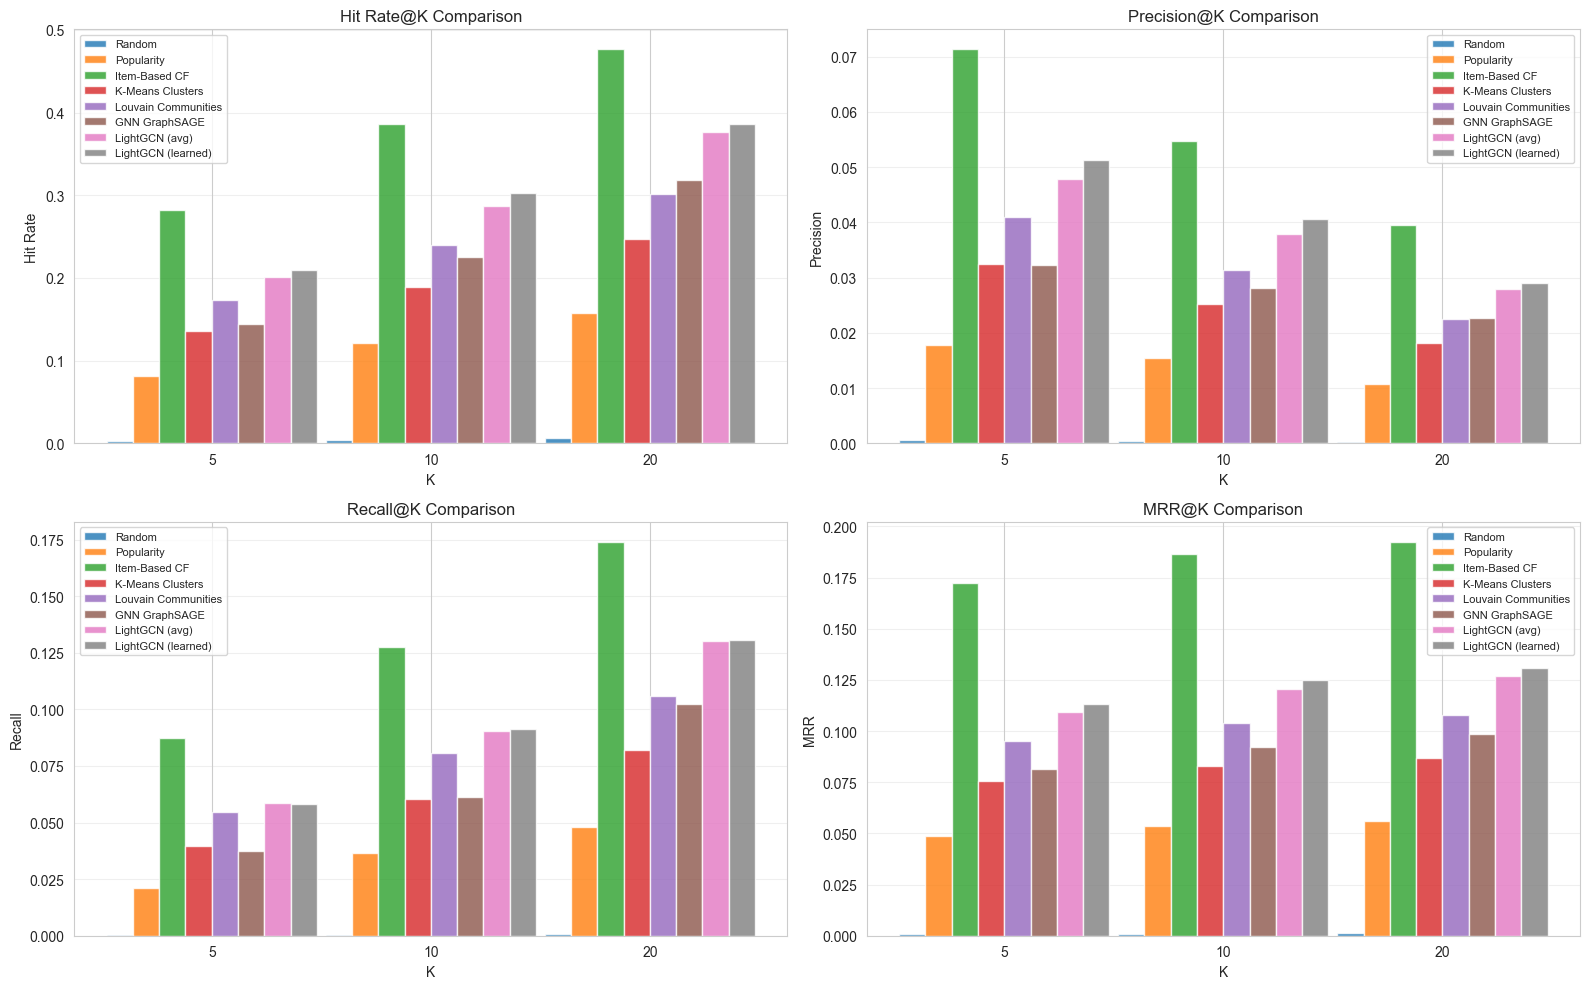

In [52]:
# Visualize performance comparison
metrics = ['hit_rate', 'precision', 'recall', 'mrr']
metric_names = ['Hit Rate', 'Precision', 'Recall', 'MRR']
k_vals = [5, 10, 20]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    x = np.arange(len(k_vals))
    width = 0.12
    offset = 0
    
    for method_name, results in all_results.items():
        scores = [results[k][metric] for k in k_vals]
        axes[idx].bar(x + offset, scores, width, label=method_name, alpha=0.8)
        offset += width
    
    axes[idx].set_xlabel('K')
    axes[idx].set_ylabel(name)
    axes[idx].set_title(f'{name}@K Comparison')
    axes[idx].set_xticks(x + width * (len(all_results) - 1) / 2)
    axes[idx].set_xticklabels(k_vals)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
